## Imports

In [107]:
import requests
import pandas as pd
import json
from datetime import datetime

# Activity 1

## 1.1 Sub-activity: Open Data API

### Task 1 and 2 using the API (for reference only)
 *This code demonstrates the implementation of Tasks 1 and 2 using the UKHSA API. Due to API limitations, data for regional metrics was instead sourced from the provided CSV files. This implementation is retained here for completeness and to demonstrate the intended approach to querying the API.

In [108]:
# Function to fetch data
def get_API_data(url, params=None):
    """
    Retrieve data from the UKHSA API.
    Args:
        url (str): The API endpoint.
        params (dict): Optional query parameters.
    Returns:
        list: List of data points from the API response.
    """
    response = requests.get(url, params=params)
    if response.ok:
        return response.json().get("results", [])
    else:
        print(f"Error {response.status_code}: {response.reason}")
        return []

# England Data: Daily Cases and Deaths
england_cases_url = "https://api.ukhsa-dashboard.data.gov.uk/themes/infectious_disease/sub_themes/respiratory/topics/COVID-19/geography_types/Nation/geographies/England/metrics/COVID-19_cases_casesByDay"
england_deaths_url = "https://api.ukhsa-dashboard.data.gov.uk/themes/infectious_disease/sub_themes/respiratory/topics/COVID-19/geography_types/Nation/geographies/England/metrics/COVID-19_deaths_deaths28DaysByPublishDate"

england_cases = get_API_data(england_cases_url, params={"page_size": 365})
england_deaths = get_API_data(england_deaths_url, params={"page_size": 365})

# Regional Data: Only Daily Deaths
regions = ["London", "North_West", "North_East", "West_Midlands", "East_Midlands"]
regional_data = []
for region in regions:
    region_deaths_url = f"https://api.ukhsa-dashboard.data.gov.uk/themes/infectious_disease/sub_themes/respiratory/topics/COVID-19/geography_types/Region/geographies/{region}/metrics/COVID-19_deaths_deaths28DaysByPublishDate"
    data = get_API_data(region_deaths_url, params={"page_size": 365})
    if data:
        regional_data.extend(data)

# Save results for Tasks 1 & 2
pd.DataFrame(england_cases).to_json("results_json_england.json", orient="records", indent=4)
pd.DataFrame(regional_data).to_json("results_json_regional.json", orient="records", indent=4)


### Task 1 and 2 using csv files

In [109]:
# Load CSV data
england_csv_path = 'england.csv'
regions_csv_path = 'regions.csv'

england_df = pd.read_csv(england_csv_path)
regions_df = pd.read_csv(regions_csv_path)

# Prepare England data for JSON
england_json = england_df.rename(columns={
    "geography": "Region",
    "metric_value_cases": "daily cases",
    "metric_value_deaths": "daily deaths"
})

# Prepare Regional data for JSON
regional_json = regions_df.rename(columns={
    "geography": "Region",
    "metric_value": "daily deaths"
})

# Save to JSON files
england_json.to_json("results_json_england.json", orient="records", indent=4)
regional_json.to_json("results_json_regional.json", orient="records", indent=4)

print("JSON files successfully generated.")


JSON files successfully generated.


## 1.2 Sub-activity: Shaping the COVID data into different dataframes

### Task 3

In [110]:
# Combine regional data into one dataframe, only keep required columns
regional_df = regions_df[["geography", "date", "metric_value"]]

### Task 4

In [111]:
# Rename columns for consistency
regional_df = regional_df.rename(columns={
    "geography": "Region",
    "metric_value": "daily deaths"
})


### Task 5

In [112]:
# Convert date column to datetime type
regional_df["date"] = pd.to_datetime(regional_df["date"])

### Task 6

In [113]:
# Print summary and check missing data
print("Summary of regional data:")
print(regional_df.describe(include='all'))


# Calculate and print missing data
missing_data = regional_df.isnull().sum()
print("\nMissing data for each column:")
print(missing_data)

Summary of regional data:
               Region                           date  daily deaths
count           12996                          12996  12996.000000
unique              9                            NaN           NaN
top     East Midlands                            NaN           NaN
freq             1444                            NaN           NaN
mean              NaN  2022-01-20 11:59:59.999999744     15.309403
min               NaN            2020-01-30 00:00:00      0.000000
25%               NaN            2021-01-24 18:00:00      3.000000
50%               NaN            2022-01-20 12:00:00      7.000000
75%               NaN            2023-01-16 06:00:00     14.000000
max               NaN            2024-01-12 00:00:00    327.000000
std               NaN                            NaN     28.393523

Missing data for each column:
Region          0
date            0
daily deaths    0
dtype: int64


### Task 7

In [114]:
# Remove missing data from England dataframe
england_df = england_df.dropna()

### Task 8

In [115]:
# Calculate 7-day rolling averages for daily cases and daily deaths in England
england_df["daily cases roll avg"] = england_df["metric_value_cases"].rolling(window=7).mean()
england_df["daily deaths roll avg"] = england_df["metric_value_deaths"].rolling(window=7).mean()

# Save results to JSON
england_df.to_json("results_json_england.json", orient="records", indent=4)
regional_df.to_json("results_json_regional.json", orient="records", indent=4)

print("Dataframes and JSON files successfully prepared.")

Dataframes and JSON files successfully prepared.


## 1.3 Sub-activity: Aggregating, plotting, and analysing


### Task 9 

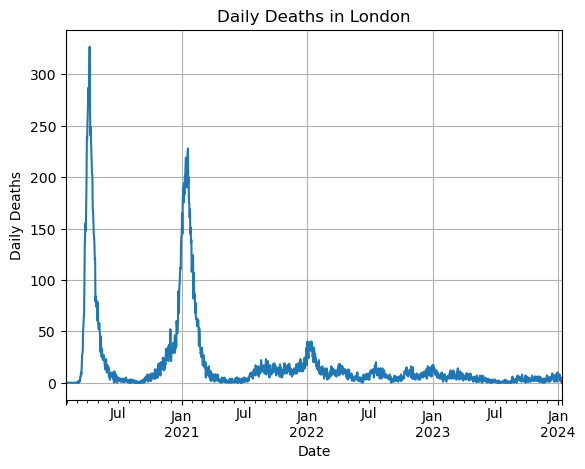

In [116]:
# Filter data for London
london_df = regional_df[regional_df["Region"] == "London"]

# Plot daily cases in London
london_df.plot(x="date", y="daily deaths", title="Daily Deaths in London", legend=False)
plt.xlabel("Date")
plt.ylabel("Daily Deaths")
plt.grid()
plt.show()

# Conclusion (to be added as a markdown cell in your notebook)
# Observation: There may be periods of plateau visible in the plot, where the number of deaths stabilizes for a certain duration.


### Task 10 

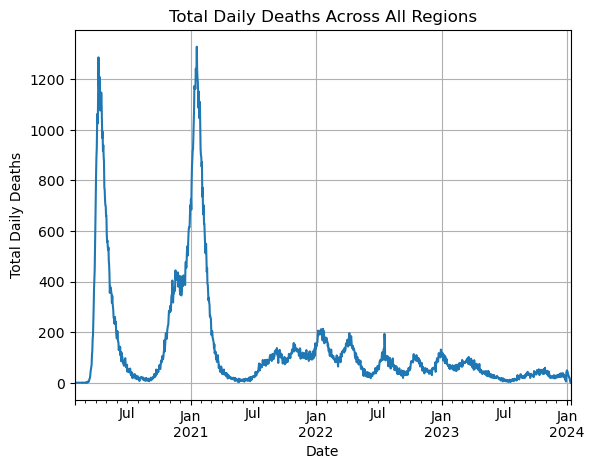

In [117]:
# Aggregate daily deaths across all regions
total_daily_deaths = regional_df.groupby("date")["daily deaths"].sum().reset_index()

# Plot evolution of daily deaths
total_daily_deaths.plot(x="date", y="daily deaths", title="Total Daily Deaths Across All Regions", legend=False)
plt.xlabel("Date")
plt.ylabel("Total Daily Deaths")
plt.grid()
plt.show()

# Conclusion
# Country-wide patterns may mirror those in London, but with larger peaks due to aggregation across all regions.


### Task 11 


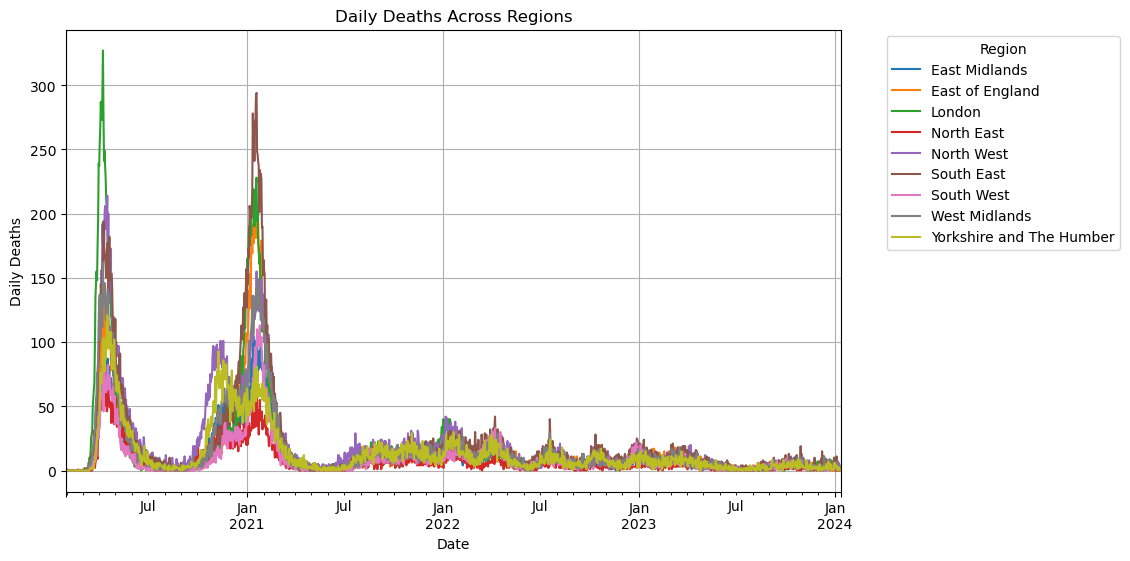

In [118]:
# Pivot data to have regions as columns
regional_pivot = regional_df.pivot(index="date", columns="Region", values="daily deaths")

# Plot evolution of daily deaths per region
regional_pivot.plot(figsize=(10, 6), title="Daily Deaths Across Regions")
plt.xlabel("Date")
plt.ylabel("Daily Deaths")
plt.legend(title="Region", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid()
plt.show()

# Conclusion
# Shared patterns include rises and falls in deaths, likely correlating with nationwide trends or external factors such as waves of infections.


### Task 12 


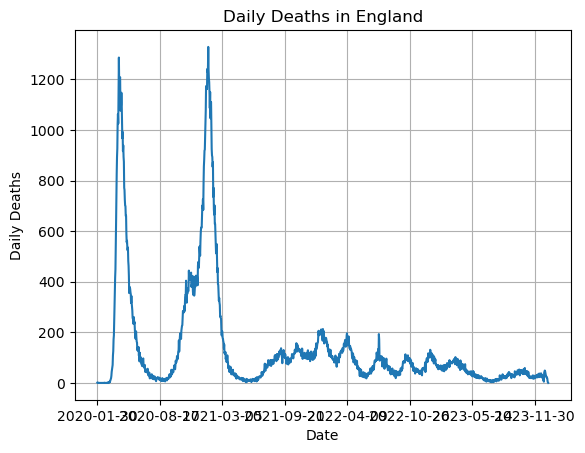

In [119]:
# Plot evolution of daily deaths in England using the correct column name
england_df.plot(x="date", y="metric_value_deaths", title="Daily Deaths in England", legend=False)
plt.xlabel("Date")
plt.ylabel("Daily Deaths")
plt.grid()
plt.show()


### Task 13 

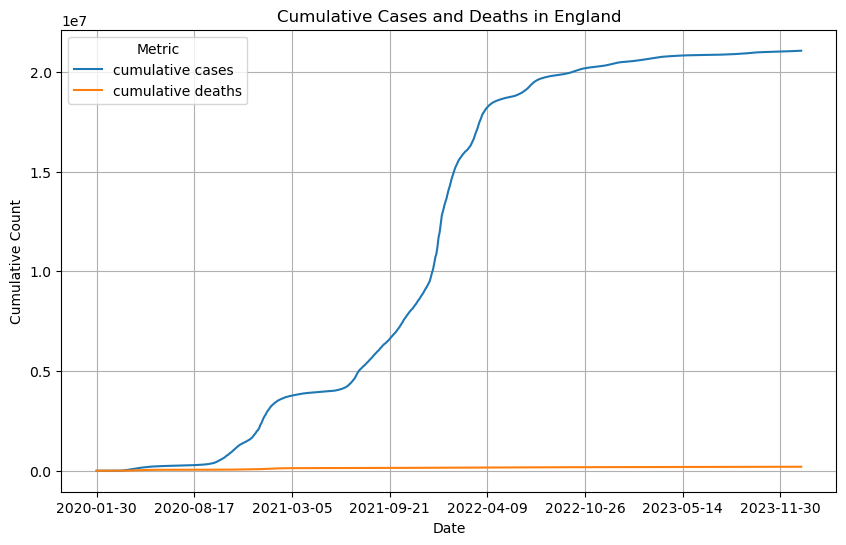

In [120]:
# Calculate cumulative cases and deaths
england_df["cumulative cases"] = england_df["metric_value_cases"].cumsum()
england_df["cumulative deaths"] = england_df["metric_value_deaths"].cumsum()

# Plot cumulative trends
england_df.plot(x="date", y=["cumulative cases", "cumulative deaths"], figsize=(10, 6), title="Cumulative Cases and Deaths in England")
plt.xlabel("Date")
plt.ylabel("Cumulative Count")
plt.legend(title="Metric")
plt.grid()
plt.show()
